In [1]:
from matplotlib import pyplot as plt
from proximal import *
import numpy as np
from scipy import ndimage
from skimage.util import random_noise
import scipy.misc
import cv2 as cv
import random



cv.setUseOptimized(True)
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
I = scipy.misc.ascent()


In [3]:
def sp_noise(image,prob=0.02):
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob/2

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob/2:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]

    return output
def gasuss_noise(image, mean, sigma):
    image = np.array(image, dtype=float)
    noise = np.random.normal(mean, sigma, image.shape)
    out = image + noise
    out = out/255

    out = np.clip(out, 0, 1)
    out = np.uint8(out*255)

    return out

In [4]:
def psnr(img_origin, img_denoised):
    img_origin = img_origin.astype(np.float64)
    img_denoised = img_denoised.astype(np.float64)
    rmse = np.sqrt(np.mean((img_origin - img_denoised)**2))
    if rmse == 0:
        print("Same image!")
    else:
        return 20 * np.log10(255. / rmse)

In [5]:
'''
mean filtering methods
'''
def mean_filter(image, size=7):
    return ndimage.uniform_filter(image, size, mode='constant', cval=0.0)

In [6]:
'''
median filtering methods
'''
def median_filter(image, size=7):
    return ndimage.median_filter(image, size, mode='constant', cval=0.0)

In [7]:
'''
TV-L2 variational model solved by the Chambolle-Pock algorithm
'''
def l2TV_cp(b, l):
    x = Variable(b.shape)
    prob = Problem(sum_squares(x - b/255) + l * norm1(grad(x)))
    prob.solve(solver='pc')
    return x.value*255
    


In [8]:
'''
TV-L1 variational model solved by the Chambolle-Pock algorithm
'''
def l1TV_cp(b, l):
    x = Variable(b.shape)
    prob = Problem(norm1(x - b/255) + l* norm1(grad(x)))
    prob.solve(solver='pc')
    return x.value*255

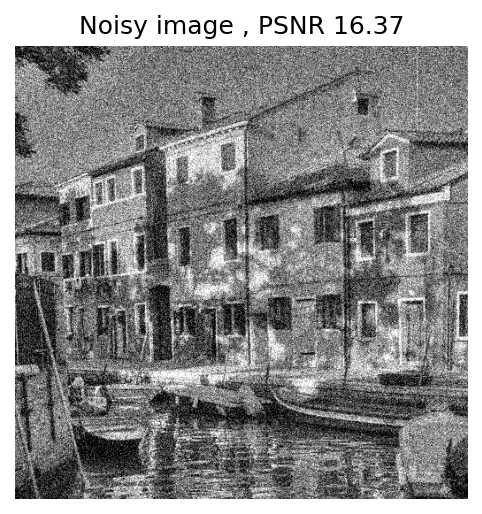

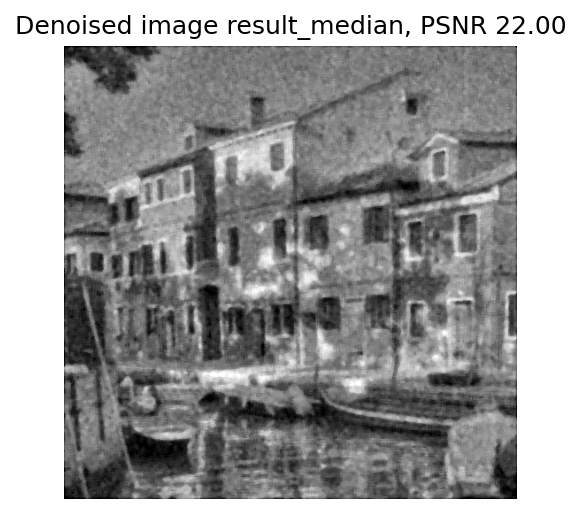

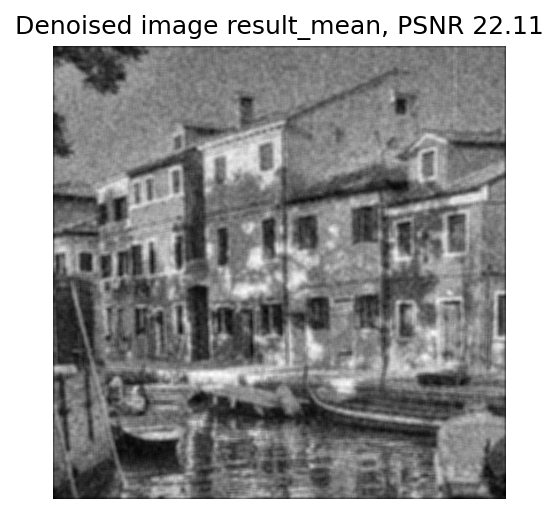

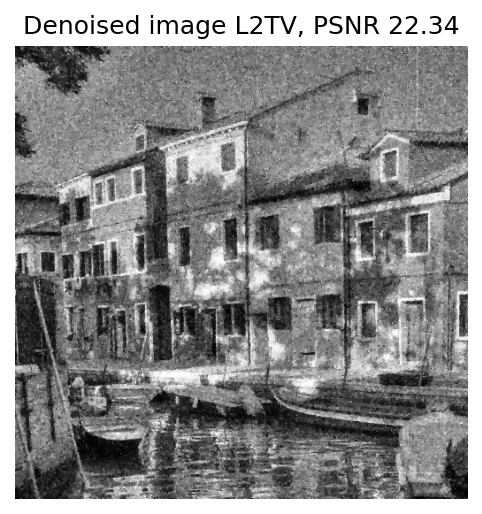

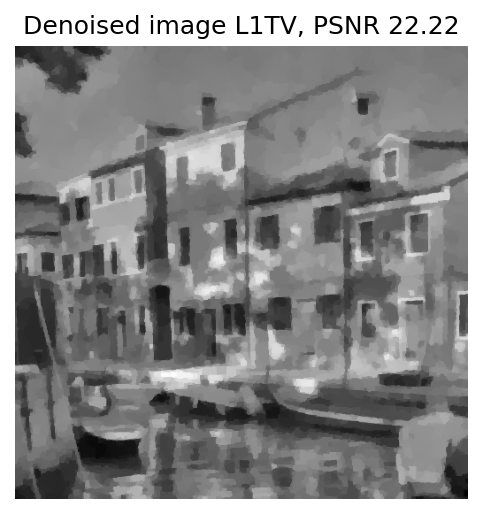

In [9]:
# read image
file = './test.jpg'
random.seed(42)
image = cv.imread(file, cv.IMREAD_GRAYSCALE)
# image = image.astype(np.float) / np.iinfo(image.dtype).max

sigma = 40
# image_noisy_sp = sp_noise(image,0.02)

image_noisy_G = gasuss_noise(image, 0, sigma)
# image_noisy_sp = random_noise(image, amount=0.02, mode='s&p', seed=42)

fig = plt.figure(dpi=150)
plt.imshow(image_noisy_G, cmap='gray')
plt.title(f'Noisy image , PSNR {psnr(image, image_noisy_G):.2f}')
plt.axis('off')
plt.show()
size = 5
result_median = median_filter(image_noisy_G, size=size)
result_mean = mean_filter(image_noisy_G, size=size)



fig = plt.figure(dpi=150)
plt.imshow(result_median, cmap='gray')
plt.axis('off')
plt.title(f'Denoised image result_median, PSNR {psnr(image, result_median):.2f}')
plt.show()
fig = plt.figure(dpi=150)
plt.imshow(result_mean, cmap='gray')
plt.axis('off')
plt.title(f'Denoised image result_mean, PSNR {psnr(image, result_mean):.2f}')
plt.show()

result_l2TV = l2TV_cp(image_noisy_G, 0.1)
result_l1TV = l1TV_cp(image_noisy_G, 1)
fig = plt.figure(dpi=150)
plt.imshow(result_l2TV, cmap='gray')
plt.axis('off')
plt.title(f'Denoised image L2TV, PSNR {psnr(image, result_l2TV):.2f}')
plt.show()
fig = plt.figure(dpi=150)
plt.imshow(result_l1TV, cmap='gray')
plt.axis('off')
plt.title(f'Denoised image L1TV, PSNR {psnr(image, result_l1TV):.2f}')
plt.show()
